## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [2]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [3]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [5]:
import json

# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [6]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [7]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.2, random_state=1, shuffle=True)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation

model_1 = Sequential()
model_1.add(Flatten(input_shape=(224, 224, 3)))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(len(categories)))
model_1.add(Activation('softmax'))

model_2 = Sequential()
model_2.add(Flatten(input_shape=(224, 224, 3)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(len(categories)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(len(categories)))
model_2.add(Activation('softmax'))

model_3 = Sequential()
model_3.add(Flatten(input_shape=(224, 224, 3)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(len(categories)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(len(categories)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(len(categories)))
model_3.add(Activation('softmax'))

model_list=[model_1, model_2, model_3]

2023-10-21 23:00:06.303644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-21 23:00:06.303739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-21 23:00:06.303785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 23:00:06.312601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 23:00:08.523711: I tensorflow/compiler/

In [9]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers.legacy import Adam, SGD

import math
from time import time


# Definir valores para tasas de aprendizaje
learning_rates = [1e-3]

# Definir optimizadores con tasas de aprendizaje específicas
optimizers = {f'adam-lr_{lr}':Adam(learning_rate=lr) for lr in learning_rates} | {f'SGD-lr_{lr}':SGD(learning_rate=lr) for lr in learning_rates}

# Almacenar los resultados de la validación
resultados = []

# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
epochs = 20
# Iterar sobre todas las combinaciones de optimizadores y tasas de aprendizaje
model_id = 1
for key, optimizer in optimizers.items():
        for model in model_list:
            model_name = 'Modelo ' + str(model_id) + ': ' + key + ' - ' + f'batch_size: {batch_size} epochs: {epochs}'
            
            print(model_name)

            model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
            
            tensorboard = TensorBoard(log_dir= 'logs_ffnn_with_dropout/'+model_name+'{}'.format(time()))

            # Entrenar el modelo con los datos de entrenamiento y validación
            h = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs, batch_size=1024, validation_data=valid_generator, validation_steps=valid_steps, verbose=1, callbacks=[tensorboard])
            
            # Best validation model
            best_idx = int(np.argmax(h.history['val_accuracy']))
            best_value = np.max(h.history['val_accuracy'])
            print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

            resultados.append({'model': str(model_id), 'learning_rate': optimizer.lr.numpy(), 'optimizer': optimizer, 'best epoch idx':best_idx+1, 'val_accuracy': best_value})
            
            if model_id == 3:
                model_id = 1
            else:
                model_id += 1

# Encontrar la mejor combinación de hiperparámetros basada en la precisión
mejor_configuracion = max(resultados, key=lambda x: x['val_accuracy'])

print("Mejor tasa de aprendizaje:", mejor_configuracion['learning_rate'])
print("Mejor optimizador:", mejor_configuracion['optimizer'])
print("Precisión en el conjunto de validación:", mejor_configuracion['val_accuracy'])

Modelo 1: adam-lr_0.001 - batch_size: 32 epochs: 20


2023-10-21 23:00:09.704874: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/20
535/535 [==============================] - 71s 131ms/step - loss: 2349.3940 - accuracy: 0.2850 - val_loss: 2131.4766 - val_accuracy: 0.3068
Epoch 2/20
535/535 [==============================] - 72s 134ms/step - loss: 2031.5432 - accuracy: 0.3207 - val_loss: 2343.9812 - val_accuracy: 0.3440
Epoch 3/20
535/535 [==============================] - 73s 137ms/step - loss: 2106.3000 - accuracy: 0.3462 - val_loss: 2959.3584 - val_accuracy: 0.3019
Epoch 4/20
535/535 [==============================] - 68s 127ms/step - loss: 2063.2068 - accuracy: 0.3446 - val_loss: 1881.6866 - val_accuracy: 0.3358
Epoch 5/20
535/535 [==============================] - 67s 126ms/step - loss: 1953.3281 - accuracy: 0.3558 - val_loss: 2952.0586 - val_accuracy: 0.2591
Epoch 6/20
535/535 [==============================] - 67s 126ms/step - loss: 2052.8396 - accuracy: 0.3624 - val_loss: 2184.0701 - val_accuracy: 0.2965
Epoch 7/20
535/535 [==============================] - 66s 124ms/step - loss: 2053.5930 - accur

In [10]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

print('Load model')
model = Sequential()

# Input layer

model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Hidden layers

model.add(Dense(len(categories)))

# Output layer

model.add(Activation('softmax'))
model.summary()

Load model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 activation_9 (Activation)   (None, 150528)            0         
                                                                 
 dropout_6 (Dropout)         (None, 150528)            0         
                                                                 
 dense_6 (Dense)             (None, 12)                1806348   
                                                                 
 activation_10 (Activation)  (None, 12)                0         
                                                                 
Total params: 1806348 (6.89 MB)
Trainable params: 1806348 (6.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
from tensorflow.keras.optimizers import Adam

# Learning rate is changed to 0.001
# opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
opt = SGD(learning_rate=1e-3, momentum=0.9, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from time import time

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
# early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
tensorboard = TensorBoard(log_dir= 'logs_ffnn/{}'.format(time()))
callbacks = [tensorboard]

In [13]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [14]:
import math
import numpy as np
print('Training model')
epochs = 50
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/50
535/535 [==============================] - 71s 129ms/step - loss: 75.8061 - accuracy: 0.2283 - val_loss: 43.0306 - val_accuracy: 0.3354
Epoch 2/50
535/535 [==============================] - 68s 128ms/step - loss: 65.4559 - accuracy: 0.2809 - val_loss: 41.2023 - val_accuracy: 0.3522
Epoch 3/50
535/535 [==============================] - 69s 128ms/step - loss: 64.3090 - accuracy: 0.2982 - val_loss: 41.5983 - val_accuracy: 0.3183
Epoch 4/50
535/535 [==============================] - 68s 127ms/step - loss: 65.5530 - accuracy: 0.3049 - val_loss: 46.5237 - val_accuracy: 0.3662
Epoch 5/50
535/535 [==============================] - 68s 127ms/step - loss: 62.8404 - accuracy: 0.3090 - val_loss: 38.6793 - val_accuracy: 0.4191
Epoch 6/50
535/535 [==============================] - 68s 127ms/step - loss: 62.0947 - accuracy: 0.3151 - val_loss: 32.8479 - val_accuracy: 0.3887
Epoch 7/50
535/535 [==============================] - 68s 128ms/step - loss: 61.5673 - accuracy: 0.3196

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [15]:
import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [16]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [17]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 22ms/step


/tmp/ipykernel_23816/612412965.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


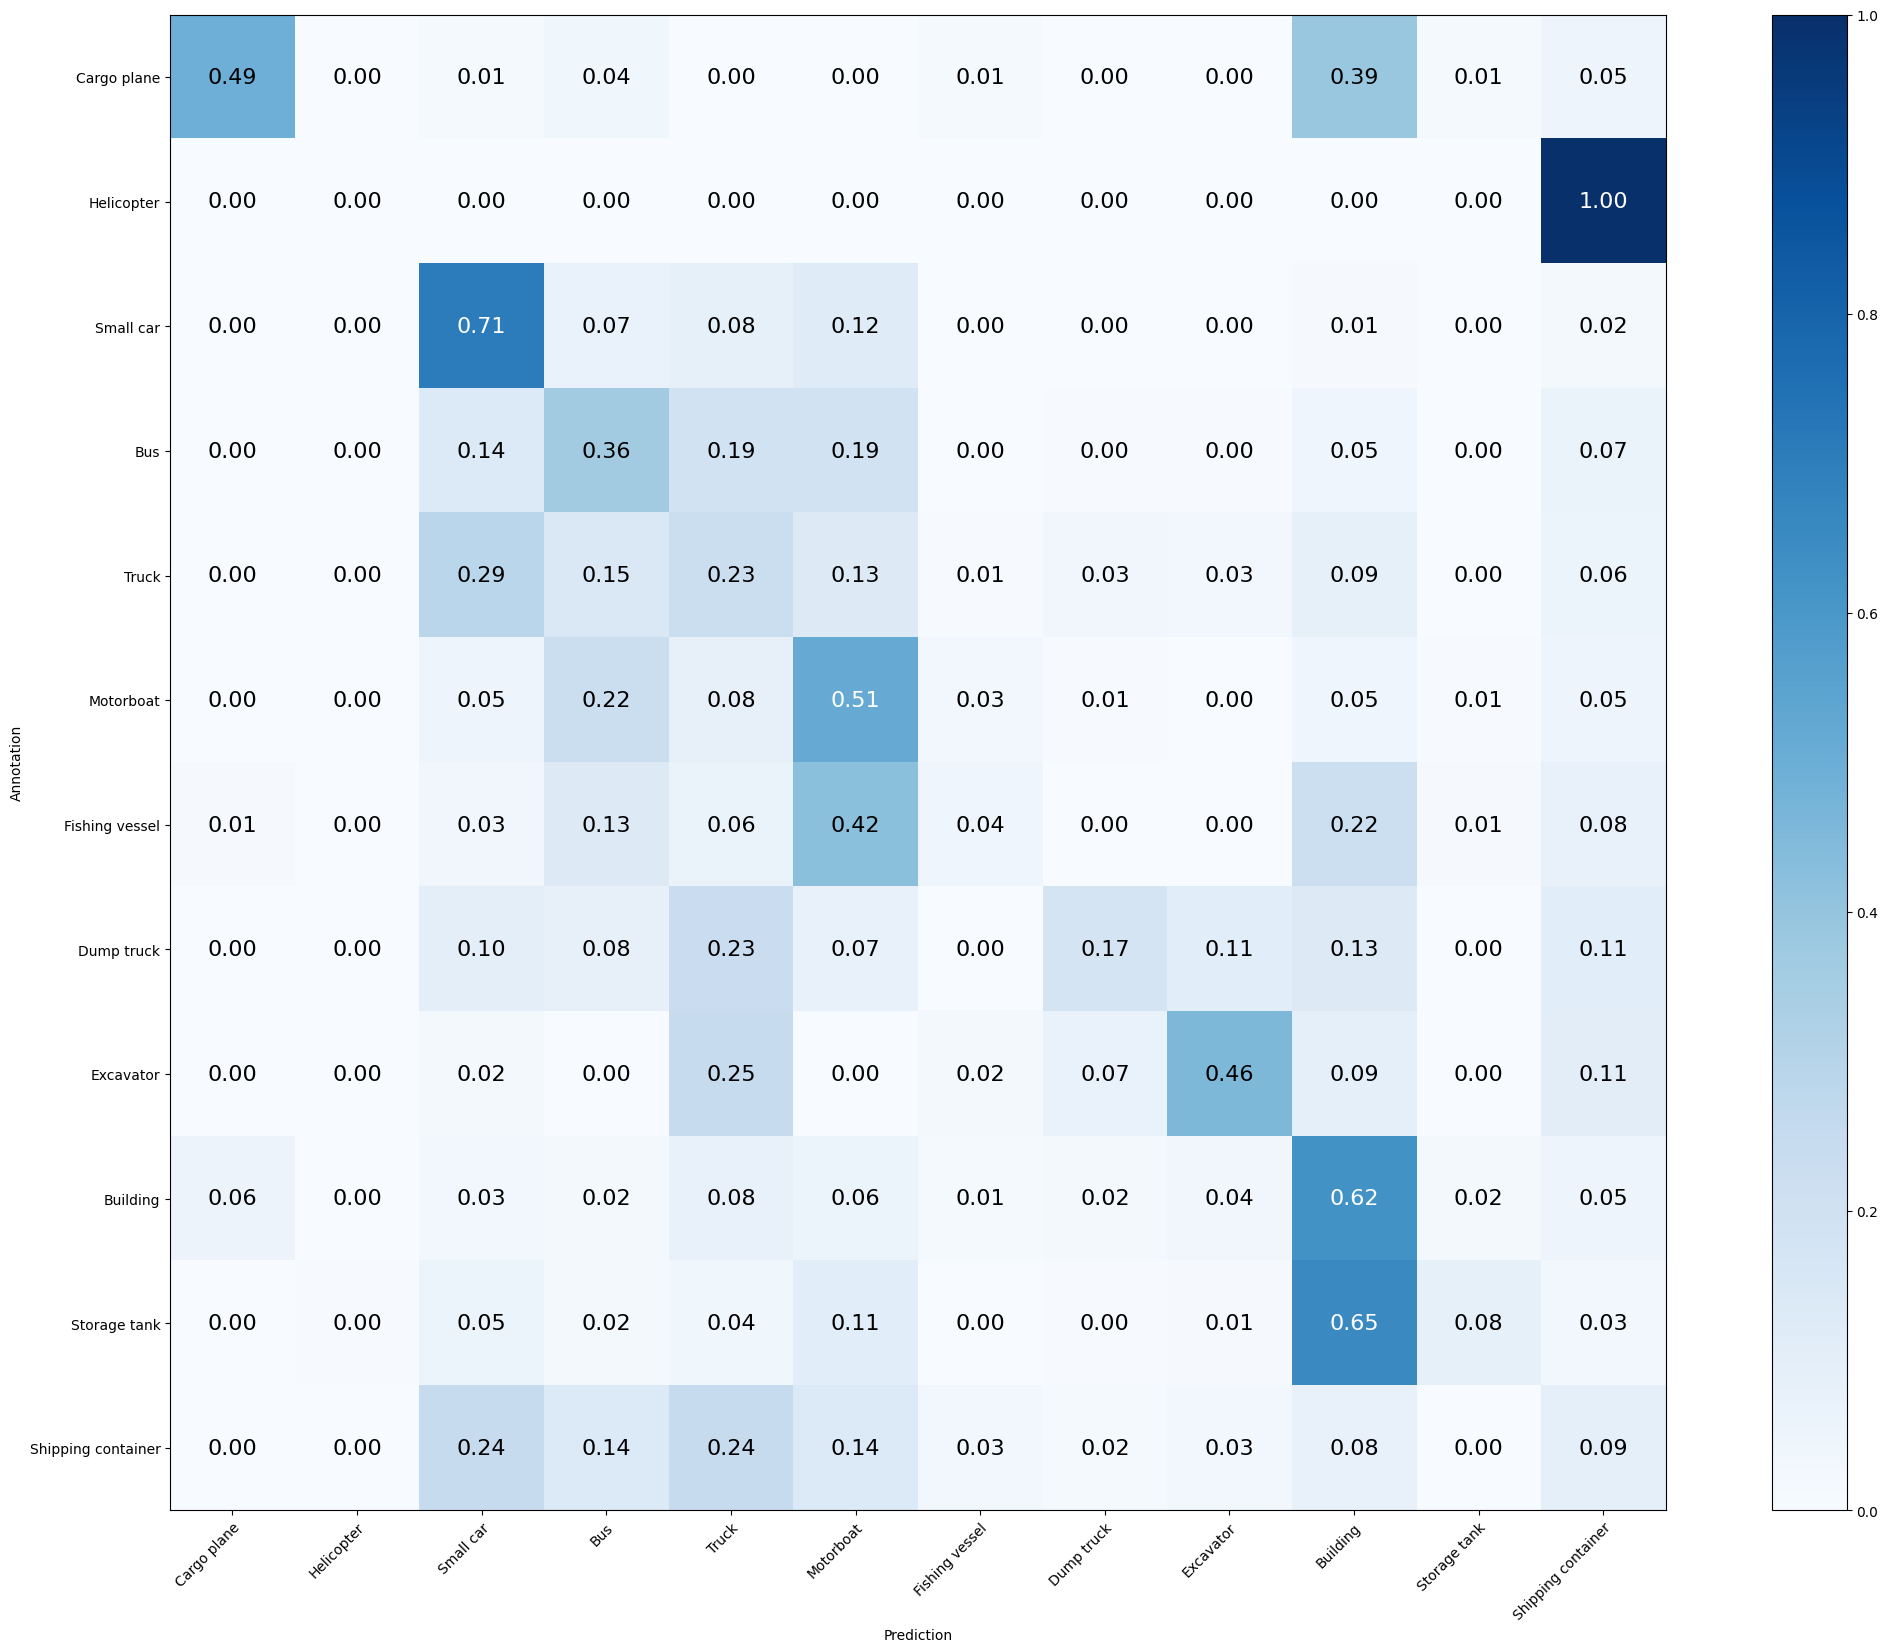

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [19]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 43.947%
Mean Recall: 31.391%
Mean Precision: 35.000%
> Cargo plane: Recall: 49.398% Precision: 56.164% Specificity: 98.746% Dice: 52.564%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 99.962% Dice: 0.000%
> Small car: Recall: 70.637% Precision: 63.235% Specificity: 90.689% Dice: 66.731%
> Bus: Recall: 35.950% Precision: 28.904% Specificity: 91.057% Dice: 32.044%
> Truck: Recall: 22.623% Precision: 22.924% Specificity: 90.043% Dice: 22.772%
> Motorboat: Recall: 51.269% Precision: 43.818% Specificity: 88.443% Dice: 47.251%
> Fishing vessel: Recall: 4.301% Precision: 14.286% Specificity: 99.056% Dice: 6.612%
> Dump truck: Recall: 17.213% Precision: 41.176% Specificity: 98.806% Dice: 24.277%
> Excavator: Recall: 45.614% Precision: 36.111% Specificity: 98.216% Dice: 40.310%
> Building: Recall: 62.362% Precision: 53.312% Specificity: 85.858% Dice: 57.483%
> Storage tank: Recall: 8.230% Precision: 55.556% Specificity: 99.331% Dice: 14.337%
> Shipping container: Re

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.

### Run all logs

In [20]:
import os
path_base = os.path.abspath(os.getcwd())
path = f"{path_base}/logs_ffnn/"
subdirs = [f'{f.path.replace(path,"").replace(" ","_").replace(":","__")}:"{f.path}"' for f in os.scandir(path) if f.is_dir()]

total_path = ",".join(subdirs)


# for index, log_directory in enumerate(subdirs):
#     cmd = f'tensorboard --logdir {log_directory} --host localhost --port {6006+index}'
#     os.system(cmd)

os.system(f'tensorboard --logdir_spec {total_path} --host localhost --port 6006')



2023-10-22 02:05:25.192627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 02:05:25.192836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 02:05:25.193131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 02:05:25.246628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 02:05:27.494501: I tensorflow/compiler/